In [141]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import date
import seaborn as sns
import random

import matplotlib.pyplot as plt


from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.mixture import GaussianMixture


from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

import scipy.stats as stats
from scipy.stats import probplot, laplace, norm, t


import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess

import pymc as pm
import arviz as az

from tensorflow import keras
#from tensorflow.keras.utils import plot_model


######################################
#from pmdarima import auto_arima
#from diptest import diptest

In [142]:
class Bayesian_PP:
    def __init__(self):
        self.log_returns = None
        self.df=None

        self.mu_prior = None
        self.sigma_prior = None
        self.mu_j_prior = None
        self.sigma_j_prior = None
        self.lamda_j_prior = None

        self.mu_samples = None
        self.sigma_samples = None
        self.mu_j_samples = None
        self.sigma_j_samples = None
        self.lamda_j_samples = None

    def log_return(self, df):
        self.df=df
        df['log_return'] = np.log(self.df / self.df.shift(1))
        self.log_returns = df['log_return'].dropna()

        '''GBM'''

        sorted = self.log_returns.sort_index()

        # Remove outliers using IQR method
        qv1 = sorted.quantile(0.25)
        qv2 = sorted.quantile(0.75)
        iqr = qv2 - qv1
        lower_bound = qv1 - 1.5 * iqr
        upper_bound = qv2 + 1.5 * iqr

        # Filter out outliers
        filtered_sorted = sorted[(sorted >= lower_bound) & (sorted <= upper_bound)]
        log_returns_values = filtered_sorted.values

        mu, sigma = stats.norm.fit(log_returns_values)

        # Compute annualized values
        mu_annual = mu * 252
        sigma_annual = sigma * np.sqrt(252)

        mu_daily_rounded, sigma_daily_rounded, mu_annual_rounded, sigma_annual_rounded  = round(mu * 100, 2), round(sigma * 100, 2), round(mu_annual * 100, 2), round(sigma_annual * 100, 2)
        print(f"Daily mu (sigma) = {mu_daily_rounded}% ± {sigma_daily_rounded}%")
        print(f"Annual mu (sigma) = {mu_annual_rounded}% ± {sigma_annual_rounded}%")

        # Setup subplots
        fig, axs = plt.subplots(3, 1, figsize=(12, 12), constrained_layout=True)

        # ─────────────────────────────
        # 1️⃣ Time Series Plot
        axs[0].plot(self.log_returns, label='Log Returns')
        axs[0].axhline(mu - 1*sigma, color='b', linestyle='--', label=f'μ - 1σ = {mu - 3*sigma:.4f}')
        axs[0].axhline(mu + 1*sigma, color='b', linestyle='--', label=f'μ + 1σ = {mu + 3*sigma:.4f}')
        axs[0].set_title('Daily Log Returns (Time Series)', fontsize=14)
        axs[0].set_xlabel('Date')
        axs[0].set_ylabel('Log Return')
        axs[0].legend()
        axs[0].grid(True)

        # ─────────────────────────────
        # 2️⃣ Histogram + Gaussian Fit
        x = np.linspace(self.log_returns.min(), self.log_returns.max(), 1000)
        pdf = stats.norm.pdf(x, mu, sigma)

        axs[1].hist(log_returns_values, bins=50, density=True, alpha=0.6, edgecolor='k', label='Histogram')
        axs[1].plot(x, pdf, 'r-', label=f'Gaussian Fit\nμ={mu:.4f}, σ={sigma:.4f}')
        axs[1].axvline(mu - 1*sigma, color='b', linestyle='--', label=f'μ - 1σ = {mu - 3*sigma:.4f}')
        axs[1].axvline(mu + 1*sigma, color='b', linestyle='--', label=f'μ + 1σ = {mu + 3*sigma:.4f}')
        axs[1].set_title('Log Returns Distribution & Gaussian Fit', fontsize=14)
        axs[1].set_xlabel('Log Return')
        axs[1].set_ylabel('Density')
        axs[1].legend()
        axs[1].grid(True)

        # ─────────────────────────────
        # 3️⃣ Q-Q Plot
        stats.probplot(log_returns_values, dist="norm", plot=axs[2])
        axs[2].get_lines()[1].set_color('red')  # Line of best fit
        axs[2].set_title('Q-Q Plot of Log Returns', fontsize=14)
        axs[2].grid(True)

        # Show all
        plt.show()

        self.mu_prior = mu
        self.sigma_prior = sigma

        ''' Merton'''

        threshold = 3 * sigma
        #Create binary jump indicator
        jump_indicator = (np.abs(self.log_returns - mu) > threshold).astype(int)

        #Resample by year and count jumps
        yearly_jump_counts = jump_indicator.resample('YE').sum()
        yearly_jump_counts.index = yearly_jump_counts.index.year

        sorted = yearly_jump_counts.sort_index()

        #Estimate λ (Poisson mean)
        # Remove outliers using IQR method
        qv1 = sorted.quantile(0.0)
        qv2 = sorted.quantile(0.75)
        iqr = qv2 - qv1
        lower_bound = qv1 - 0 * iqr
        upper_bound = qv2 + 0 * iqr

        # Filter out outliers
        filtered_sorted = sorted[(sorted >= lower_bound) & (sorted <= upper_bound)]
        yearly_jump_counts_values = filtered_sorted.values

        lambda_j = yearly_jump_counts_values.mean()

        ###
        # Theoretical quantiles from Poisson
        n = len(yearly_jump_counts_values)
        quantiles = np.linspace(0.01, 0.99, n)
        percentiles = np.quantile(yearly_jump_counts_values, quantiles)
        theoretical_q = stats.poisson.ppf(quantiles, mu=lambda_j)

        # Create subplots
        fig, axs = plt.subplots(1, 2, figsize=(14, 5))

        # --- Plot 1: Histogram with Poisson PMF ---
        axs[0].hist(yearly_jump_counts_values, bins=range(int(max(yearly_jump_counts_values))+2),
                    density=True, alpha=0.6, edgecolor='k', label='Observed')

        x = np.arange(0, max(yearly_jump_counts_values)+1)
        pmf = stats.poisson.pmf(x, mu=lambda_j)
        axs[0].plot(x, pmf, 'ro-', label=f'Poisson PMF (λ={lambda_j:.2f})')

        axs[0].set_title("Poisson Fit to Yearly Jump Counts")
        axs[0].set_xlabel("Jump Count per Year")
        axs[0].set_ylabel("Probability")
        axs[0].legend()
        axs[0].grid(True)

        # --- Plot 2: Q-Q Plot ---
        axs[1].plot(theoretical_q, percentiles, 'bo', label='Empirical vs Poisson')
        axs[1].plot([0, max(theoretical_q.max(), yearly_jump_counts_values.max())],
                    [0, max(theoretical_q.max(), yearly_jump_counts_values.max())],
                    'r--', label='Ideal Fit (y = x)')

        axs[1].set_title("Q-Q Plot: Empirical vs Poisson Quantiles")
        axs[1].set_xlabel("Theoretical Quantiles (Poisson)")
        axs[1].set_ylabel("Empirical Quantiles (Observed)")
        axs[1].legend()
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

        # Estimate mu_J and sigma_J (jump size stats)
        jump_sizes = self.log_returns.loc[np.abs(self.log_returns - mu) > threshold].dropna() #Extract jump sizes

        sorted = jump_sizes.sort_index()

        # Remove outliers using IQR method
        qv1 = sorted.quantile(0.25)
        qv2 = sorted.quantile(0.75)
        iqr = qv2 - qv1
        lower_bound = qv1 - 2.5 * iqr
        upper_bound = qv2 + 2.5 * iqr

        # Filter out outliers
        filtered_sorted = sorted[(sorted >= lower_bound) & (sorted <= upper_bound)]
        jump_sizes_values = filtered_sorted.values

        # Fit normal distribution
        mu_J, sigma_J = norm.fit(jump_sizes_values)

        # Create subplots: 1 row, 2 columns
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))

        # Histogram with fitted normal curve
        axs[0].hist(jump_sizes_values, bins=20, density=True, alpha=0.6, color='skyblue', edgecolor='black')
        xmin, xmax = axs[0].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu_J, sigma_J)
        axs[0].plot(x, p, 'r', linewidth=2)
        axs[0].set_title("Histogram of Jump Sizes with Fitted Normal Curve")
        axs[0].set_xlabel("Jump Size")
        axs[0].set_ylabel("Density")
        axs[0].grid(True)
        # Add mu_J and sigma_J to the plot
        textstr = f"$\\mu_J$ = {mu_J:.4f}\n$\\sigma_J$ = {sigma_J:.4f}"
        axs[0].text(0.95, 0.95, textstr,
                    transform=axs[0].transAxes,
                    fontsize=12,
                    verticalalignment='top',
                    horizontalalignment='right',
                    bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray", alpha=0.8))

        # Q-Q plot
        probplot(jump_sizes_values, dist="norm", sparams=(mu_J, sigma_J), plot=axs[1])
        axs[1].set_title("Q-Q Plot vs Fitted Normal")
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

        self.mu_j_prior = mu_J
        self.sigma_j_prior = sigma_J
        self.lamda_j_prior = lambda_j

        return self.mu_prior, self.sigma_prior, self.mu_j_prior, self.sigma_j_prior, self.lamda_j_prior


    """Fit a Bayesian model to estimate mu and sigma."""
    def fit_bayesian_model(self, nsample, nburn, nchain):

        with pm.Model() as model:

            # Prior for mu
            mu = pm.Normal("mu", mu=self.mu_prior, sigma=self.sigma_prior)

            #Prior for sigma
            #sigma_squared = pm.InverseGamma("sigma_squared", alpha=2, beta=self.sigma_prior)
            #igma = pm.Deterministic("sigma", pm.math.sqrt(sigma_squared))

            sigma = pm.HalfNormal("sigma", sigma=self.sigma_prior)

            # Likelihood (observed log returns)
            obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=self.log_returns)

            # Sampling (using Metropolis algorithm)
            step = pm.Metropolis()
            trace = pm.sample(nsample+nburn, step=step, tune=nburn, chains=nchain, return_inferencedata=True, random_seed=42)

        az.plot_trace(trace, var_names=["mu", "sigma"])
        plt.tight_layout()
        plt.show()
        az.plot_autocorr(trace, var_names=["mu", "sigma"])
        plt.tight_layout()
        plt.show()
        summary = az.summary(trace, var_names=["mu", "sigma"], round_to=4)
        print(summary)

        # Extract posterior samples
        self.mu_samples = trace.posterior['mu'].values.flatten()
        self.sigma_samples = trace.posterior['sigma'].values.flatten()

        return self.mu_samples, self.sigma_samples



In [143]:
class Stochastic_prices_MC:
    def __init__(self, df, nfuture, last_price ,npath, mu_samples, sigma_samples, mu_j_samples, sigma_j_samples, lambda_j_samples, rfr, risk_neutral = True):
        self.nfuture = nfuture
        self.df = df
        self.rfr = rfr
        self.risk_neutral = risk_neutral
        self.npath = npath
        self.last_price = last_price
        self.simulated_prices = None

        self.mu_samples = mu_samples
        self.sigma_samples = sigma_samples
        self.mu_j_samples = mu_j_samples
        self.sigma_j_samples = sigma_j_samples
        self.lamda_j_samples = lambda_j_samples



    def simulate_future_prices_Merton(self):
        # Initialize a 2D array for all simulations (each row is one simulation)
        simulated_prices = np.zeros((self.npath, self.nfuture + 1))

        simulated_prices[:, 0] = self.last_price  # Set initial price for all paths

        dt = 1 / 252  # Daily time step
        mu_sample = self.mu_samples[0]
        sigma_sample = self.sigma_samples[0]
        mu_j_sample = self.mu_j_samples[0]
        sigma_j_sample = self.sigma_j_samples[0]
        lamda_j_year = self.lamda_j_samples[0]
        lamda_j_sample = lamda_j_year * dt

        for ii in range(self.npath):
                for t in range(1, self.nfuture + 1):
                    #Semi-analytical solution
                    z = np.random.normal(0, 1, 1)
                    NN = np.random.poisson(lam=lamda_j_sample, size=1)[0]
                    J_NN=np.random.normal(mu_j_sample, sigma_j_sample, NN)

                    first_term = -lamda_j_sample * (np.exp(mu_j_sample + 0.5 * sigma_j_sample**2) -1) *dt
                    second_term = np.sum(J_NN)

                    if self.risk_neutral:
                        jump_term = (first_term + second_term)
                        simulated_prices[ii, t] = simulated_prices[ii, t - 1] * np.exp((self.rfr - 0.5 * sigma_sample**2) * dt + sigma_sample * np.sqrt(dt) * z + jump_term)
                    else:
                        jump_term =  second_term
                        simulated_prices[ii, t] = simulated_prices[ii, t - 1] * np.exp((mu_sample - 0.5 * sigma_sample**2) * dt + sigma_sample * np.sqrt(dt) * z + jump_term)


                        #Euler-Maruyama Discretization
                        '''
                        z = np.random.normal(0, 1, 1)
                        NN=np.random.poisson(lamda_j_sample*dt)
                        J=np.random.normal(mu_j_sample, sigma_j_sample)
                        simulated_prices[ii, t] = simulated_prices[ii, t - 1] * (1 + mu_sample * dt + sigma_sample * np.sqrt(dt) * random + (J-1) * NN)
                        '''
        self.simulated_prices = simulated_prices
        return simulated_prices

    def simulate_future_prices_GBM(self):
        # Initialize a 2D array for all simulations (each row is one simulation)
        simulated_prices = np.zeros((self.npath, self.nfuture + 1))

        simulated_prices[:, 0] = self.last_price  # Set initial price for all paths

        dt = 1 / 252  # Daily time step
        mu_sample = self.mu_samples[0]
        sigma_sample = self.sigma_samples[0]

        for ii in range(self.npath):
                for t in range(1, self.nfuture + 1):
                    #Analytical solution
                    z = np.random.normal(0, 1, 1)

                    if self.risk_neutral:
                        simulated_prices[ii, t] = simulated_prices[ii, t - 1] * np.exp((self.rfr - 0.5 * sigma_sample**2) * dt + sigma_sample * np.sqrt(dt) * z)
                    else:
                        simulated_prices[ii, t] = simulated_prices[ii, t - 1] * np.exp((mu_sample - 0.5 * sigma_sample**2) * dt + sigma_sample * np.sqrt(dt) * z)
                        #Euler-Maruyama Discretization
                        '''
                        z = np.random.normal(0, 1, 1)
                        simulated_prices[ii, t] = simulated_prices[ii, t - 1] * (1 + mu_sample * dt + sigma_sample * np.sqrt(dt) * z)
                        '''
        self.simulated_prices = simulated_prices
        return simulated_prices

    def simulate_future_prices_btree(self):
        # Initialize a 2D array for all simulations (each row is one simulation)
        simulated_prices = np.zeros((self.npath, self.nfuture + 1))

        simulated_prices[:, 0] = self.last_price  # Set initial price for all paths

        dt = 1 / 252  # Daily time step

        mu_sample = self.mu_samples[0]
        sigma_sample = self.sigma_samples[0]
        u = np.exp(sigma_sample * np.sqrt(dt))
        d = 1 / u

        for ii in range(self.npath):
                for t in range(1, self.nfuture + 1):
                    #Analytical solution COX-Ross-Rubinstein model
                    ur = np.random.rand()

                    if self.risk_neutral:
                        p = (np.exp(self.rfr * dt) - d) / (u - d)
                        move = ur < p  # True = up, False = down
                        simulated_prices[ii, t] = simulated_prices[ii, t - 1] * (u if move else d)
                    else:
                        p = (np.exp(self.mu_sample * dt) - d) / (u - d)
                        move = ur < p  # True = up, False = down
                        simulated_prices[ii, t] = simulated_prices[ii, t - 1] * (u if move else d)

        self.simulated_prices = simulated_prices
        return simulated_prices

    def plot_monte_carlo(self, simulated_prices, split_index):
        print ("Today's value = ", self.df.iloc[-1])

        plt.figure(figsize=(12, 6))
        plt.plot(self.df[:], color='black', alpha=1, label="Historical Price")

        std_path = np.std(simulated_prices, axis=0)
        mean_path = np.mean(simulated_prices, axis=0)

        plt.plot(self.df.index[split_index-1:], mean_path, color='blue', alpha=1, label="Mean Forecast")
        plt.fill_between(self.df.index[split_index-1:], mean_path - std_path, mean_path + std_path,
                     color='orange', alpha=0.2, label="±1 Std Dev")
        plt.axvline(x=self.df.index[split_index], color='k', linestyle='--', label='Train/Test split')

        plt.title(f"Simulated Future Stock Prices (Bayesian GBM)")
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.tight_layout()
        plt.legend()
        plt.show()

        final_prices = simulated_prices[:, -1]
        mu_final = np.mean(final_prices)
        std_final = np.std(final_prices)
        ci_lower, ci_upper = np.percentile(final_prices, [2.5, 97.5])

        plt.figure(figsize=(10, 5))

        # Histogram
        sns.histplot(final_prices, bins=50, kde=False, stat="density", color="skyblue", edgecolor="gray", label="Simulated Final Prices")

        # Fit and plot Gaussian
        x_vals = np.linspace(final_prices.min(), final_prices.max(), 200)
        pdf_vals = stats.norm.pdf(x_vals, mu_final, std_final)
        plt.plot(x_vals, pdf_vals, color='red', lw=2, label="Fitted Normal")

        # Mean line
        plt.axvline(mu_final, color='black', linestyle='--', label=f"Mean = {mu_final:.2f}")

        # ±1 Std Dev
        plt.axvspan(mu_final - std_final, mu_final + std_final, color='orange', alpha=0.2, label=f"±1 Std Dev")

        # 95% CI
        plt.axvline(ci_lower, color='blue', linestyle='--', alpha=0.8, label=f"95% CI = [{ci_lower:.2f}, {ci_upper:.2f}]")
        plt.axvline(ci_upper, color='blue', linestyle='--', alpha=0.8)

        plt.title("Distribution of Simulated Final Stock Prices")
        plt.xlabel("Final Price")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def price_european_options(self, S_maturity, maturity_years, strike_price_calls, strike_price_puts, records):
        # Initialize empty arrays for option prices
        call_price = np.zeros(len(maturity_years))
        put_price = np.zeros(len(maturity_years))
        mean_S_maturity = np.zeros(len(maturity_years))

        # Loop over each maturity year
        for i in range(len(maturity_years)):
            # Get the payoff for call and put options
            call_payoffs = np.maximum(S_maturity[i] - strike_price_calls[i], 0)
            put_payoffs = np.maximum(strike_price_puts[i] - S_maturity[i], 0)

            # Discount the payoffs back to present value
            discount_factor = np.exp(-self.rfr * maturity_years[i])
            call_price[i] = discount_factor * np.mean(call_payoffs)
            put_price[i] = discount_factor * np.mean(put_payoffs)
            mean_S_maturity[i] = np.mean(S_maturity[i])

        # Update the records DataFrame with the prices and mean of the maturity values
        records['Maturity'] = maturity_years
        records['CallPrice'] = call_price
        records['PutPrice'] = put_price
        records['Mean S_maturity'] = mean_S_maturity

        return records

    def price_european_options_btree(self, S_maturity, maturity_years, strike_price_calls, strike_price_puts, records):
        # Initialize empty arrays for option prices
        call_price = np.zeros(len(maturity_years))
        put_price = np.zeros(len(maturity_years))
        mean_S_maturity = np.zeros(len(maturity_years))


        dt = 1 / 252  # daily steps
        u = np.exp(self.sigma_samples[0] * np.sqrt(dt))
        d = 1 / u
        p = (np.exp(self.rfr * dt) - d) / (u - d)

        for j in range(len(maturity_years)):
            maturity_prices = S_maturity[j]
            n_steps = len(maturity_prices) - 1  # assumes full tree layer

            # Get payoffs at maturity
            call_vals = np.maximum(maturity_prices - strike_price_calls[j], 0)
            put_vals = np.maximum(strike_price_puts[j] - maturity_prices, 0)

            # Work backward through the tree
            for step in range(n_steps, 0, -1):
                call_vals = np.exp(-self.rfr * dt) * (p * call_vals[1:] + (1 - p) * call_vals[:-1])
                put_vals = np.exp(-self.rfr * dt) * (p * put_vals[1:] + (1 - p) * put_vals[:-1])

            # Final result at the root of the tree
            call_price[j] = call_vals[0]
            put_price[j] = put_vals[0]
            mean_S_maturity[j] = np.mean(maturity_prices)

        # Update the records DataFrame with the prices and mean of the maturity values
        records['Maturity'] = maturity_years
        records['CallPrice'] = call_price
        records['PutPrice'] = put_price
        records['Mean S_maturity'] = mean_S_maturity

        return records

In [144]:
class options_value:
    def __init__(self):
        self.value = None

    def black_scholes(self, S0, K, T, r, sigma, option_type='call'):
        d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        if option_type == 'call':
            price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        elif option_type == 'put':
            price = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)

        return price


In [145]:
class StockData:
    def __init__(self, ticker, start, end, column):
        self.ticker = ticker
        self.start = start
        self.end = end
        self.df = None
        self.column=column

    def fetch_data(self):
        self.df = yf.download(self.ticker, start=self.start, end=self.end)

        self.df = self.df.sort_index()
        self.df = self.df.dropna()
        self.df.info()

        #PLOT
        ax = self.df.drop(columns=["Volume"]).plot(figsize=(12, 6), title=self.ticker + "Stock Prices")
        ax.set_ylabel("Stock Price")
        ax2 = ax.twinx()
        ax2.set_ylabel("Volume")
        ax2.plot(self.df.index, self.df["Volume"], color="gray", alpha=0.5, linestyle="dashed", label="Volume")
        ax2.legend(loc="upper left")
        plt.show()

        self.df.columns = self.df.columns.get_level_values(0)
        new_df = self.df[[self.column]].copy()
        new_df.info()

        self.CAGR(new_df)
        return new_df

    def download_option_data(self):
        # Create a Ticker object
        stock = yf.Ticker(self.ticker)

        # Get available expiration dates
        expirations = stock.options
        print("Available Expirations:", expirations)

        first_strike_call=[]
        first_strike_put=[]
        call_price=[]
        put_price=[]
        IV_call = []
        IV_put = []

        expirations_values=[]

        for i in range(len(expirations)):
            opt_chain = stock.option_chain(expirations[i])
            calls = opt_chain.calls
            puts = opt_chain.puts

            if  i==0:
               print (calls.head())
               print (puts.head())

            # Sort by strike price to get the first (lowest)
            calls_sorted = calls.sort_values("strike")
            puts_sorted = puts.sort_values("strike")

            #nrange = np.minimum(len(calls_sorted.index), len(puts_sorted.index))
            nrange = 1
            for ii in range(nrange):
                call_price.append(calls_sorted['lastPrice'].iloc[ii])
                first_strike_call.append(calls_sorted['strike'].iloc[ii])
                IV_call.append(calls_sorted['impliedVolatility'].iloc[ii])
                expirations_values.append(expirations[i])

            for ii in range(nrange):
                put_price.append(puts_sorted['lastPrice'].iloc[ii])
                first_strike_put.append(puts_sorted['strike'].iloc[ii])
                IV_put.append(puts_sorted['impliedVolatility'].iloc[ii])

        records = pd.DataFrame()
        records['expirations'] = np.array(expirations_values)
        records['call_strike'] = np.array(first_strike_call)
        records['call_price'] = np.array(call_price)
        records['IV_call'] = np.array(IV_call)
        records['put_strike'] = np.array(first_strike_put)
        records['put_price'] = np.array(put_price)
        records['IV_put'] = np.array(IV_put)

        return np.array(expirations_values), np.array(first_strike_call), np.array(first_strike_put), records

    #change to OOP later
    def CAGR(self, df):
        # Ensure the DataFrame index is datetime
        df = df.sort_index()
        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError("DataFrame index must be a DatetimeIndex.")

        yearly_cagr = {}
        cumulative_cagr = {}

        years = sorted(df.index.year.unique())

        # Use the second year as the start to avoid incomplete initial data
        start_year = years[0]
        start_date = df[df.index.year == start_year].index[0]
        start_value = df.loc[start_date].values[0]

        for year in years:  # Skip the first year
            # Yearly CAGR
            yearly_df = df[df.index.year == year]
            start = yearly_df.iloc[0].values[0]
            end = yearly_df.iloc[-1].values[0]
            days = (yearly_df.index[-1] - yearly_df.index[0]).days
            if days > 0:
                yearly_cagr[year] = (end / start) ** (365.25 / days) - 1

            # Cumulative CAGR from start_year to current year
            end_value = df[df.index.year <= year].iloc[-1].values[0]
            total_days = (df[df.index.year <= year].index[-1] - start_date).days
            if total_days > 0:
                cumulative_cagr[year] = (end_value / start_value) ** (365.25 / total_days) - 1

        # Plot
        plt.figure(figsize=(12, 6))

        # Yearly CAGR line
        plt.plot(yearly_cagr.keys(), [v * 100 for v in yearly_cagr.values()],
                marker='o', label='Yearly CAGR')

        # Cumulative CAGR line
        cumulative_values = [v * 100 for v in cumulative_cagr.values()]
        plt.plot(cumulative_cagr.keys(), cumulative_values,
                marker='s', linestyle='--', label='Cumulative CAGR')

        # Annotate cumulative CAGR values
        for year, val in cumulative_cagr.items():
            plt.text(year, val * 100 + 0.5, f"{val * 100:.2f}%", ha='center', fontsize=8, color='blue')

        plt.axhline(0, color='black', linewidth=0.5)
        plt.title("Yearly vs Cumulative CAGR of NIFTY Close Prices")
        plt.xlabel("Year")
        plt.ylabel("CAGR (%)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

In [154]:
class OptionPredictor:
    def __init__(self, ticker, start, end, column, nfuture = 252):

        self.ticker = ticker
        self.start = start
        self.end = end
        self.model_type = None
        self.df=None
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.nfuture = nfuture
        self.column=column
        self.rfr = 0.07
        self.risk_neutral = True
        self.expirations = None
        self.calls_strike = None
        self.puts_strike = None
        self.rfr = 0.06

        self.mu_samples = None
        self.sigma_samples = None
        self.mu_j_samples = None
        self.sigma_j_samples = None
        self.lambda_j_samples = None
        self.records = None

    def data_initiation(self):
        self.df = StockData(self.ticker, self.start, self.end, self.column).fetch_data()
        self.expirations, self.calls_strike, self.puts_strike, self.records = StockData(self.ticker, self.start, self.end, self.column).download_option_data()

    def parameters(self):
        bayesian = Bayesian_PP()
        mu_prior, sigma_prior, mu_j_prior, sigma_j_prior, lamda_j_prior = bayesian.log_return(self.df[self.column].iloc[:])

        self.mu_samples, self.sigma_samples = np.array([mu_prior]).flatten(), np.array([sigma_prior]).flatten()
        self.mu_j_samples, self.sigma_j_samples, self.lambda_j_samples = np.array([mu_j_prior]).flatten(), np.array([sigma_j_prior]).flatten(), np.array([lamda_j_prior]).flatten()

    def run_mcmc(self, npath,  model_type):
        self.record=[]
        S_maturity = np.zeros((len(self.expirations), npath))

        start = pd.to_datetime(self.df.index[-1])
        expirations = pd.to_datetime(self.expirations)
        business_days = np.array([np.busday_count(start.date(), exp.date()) for exp in expirations])
        maturity_years = business_days / 252

        for i in range(len(self.expirations)):

            self.model = Stochastic_prices_MC (self.df[self.column], business_days[i], self.df[self.column].iloc[-1], npath, self.mu_samples, self.sigma_samples,  self.mu_j_samples, self.sigma_j_samples, self.lambda_j_samples, self.rfr, self.risk_neutral)

            if model_type == 'BinomialTree':
                simulated_prices = self.model.simulate_future_prices_btree()
            elif model_type == 'GBM':
                simulated_prices = self.model.simulate_future_prices_GBM()
            elif model_type == 'Merton':
                simulated_prices = self.model.simulate_future_prices_Merton()

            S_maturity[i] = simulated_prices[:, -1]

        if model_type == 'BinomialTree':
            self.records = self.model.price_european_options_btree(S_maturity, maturity_years, self.calls_strike, self.puts_strike, self.records)
        else:
            self.records = self.model.price_european_options(S_maturity, maturity_years, self.calls_strike, self.puts_strike, self.records)

        print (self.records)

    def run_sde(self, model_type):
        self.record=[]
        start = pd.to_datetime(self.df.index[-1])
        expirations = pd.to_datetime(self.expirations)
        business_days = np.array([np.busday_count(start.date(), exp.date()) for exp in expirations])
        maturity_years = business_days / 252

        call_price =  np.zeros(len(maturity_years))
        put_price = np.zeros(len(maturity_years))
        self.model = options_value()

        for i in range(len(self.expirations)):

            if model_type == 'GBM':
                call_price[i] = self.model.black_scholes(self.df[self.column].iloc[-1], self.calls_strike[i], maturity_years[i], self.rfr, self.sigma_samples[0], 'call')
                put_price[i] = self.model.black_scholes(self.df[self.column].iloc[-1], self.puts_strike[i], maturity_years[i], self.rfr, self.sigma_samples[0], 'put')

            elif model_type == 'Merton':
                call_price[i] = self.model.black_scholes(self.df[self.column].iloc[-1], self.calls_strike[i], maturity_years[i], self.rfr, self.sigma_samples[0], 'call')
                put_price[i] = self.model.black_scholes(self.df[self.column].iloc[-1], self.puts_strike[i], maturity_years[i], self.rfr, self.sigma_samples[0], 'put')

        self.records['Maturity'] = maturity_years
        self.records['CallPrice'] = call_price
        self.records['PutPrice'] = put_price

        print (self.records)



[*********************100%***********************]  1 of 1 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2842 entries, 2014-01-02 to 2025-04-21
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (Close, IBN)   2842 non-null   float64
 1   (High, IBN)    2842 non-null   float64
 2   (Low, IBN)     2842 non-null   float64
 3   (Open, IBN)    2842 non-null   float64
 4   (Volume, IBN)  2842 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 133.2 KB


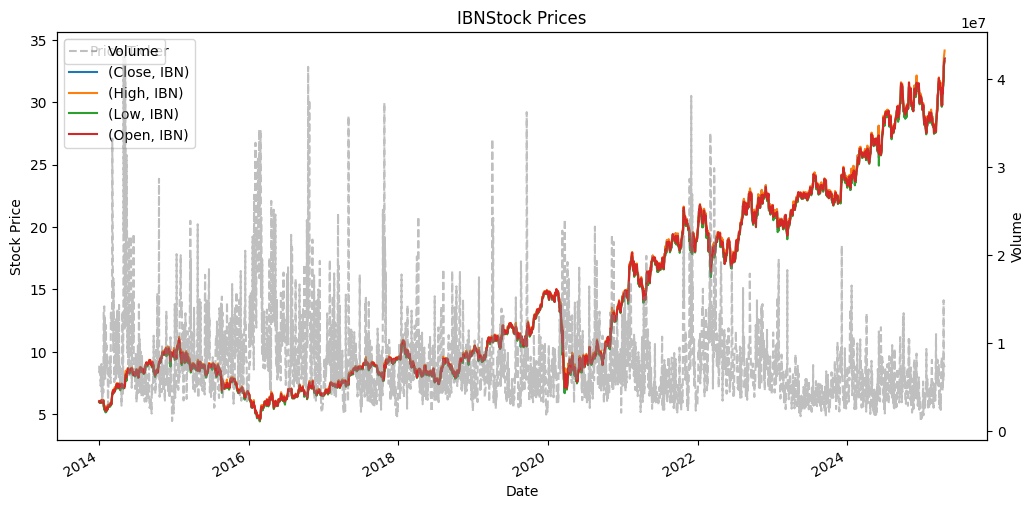

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2842 entries, 2014-01-02 to 2025-04-21
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2842 non-null   float64
dtypes: float64(1)
memory usage: 44.4 KB


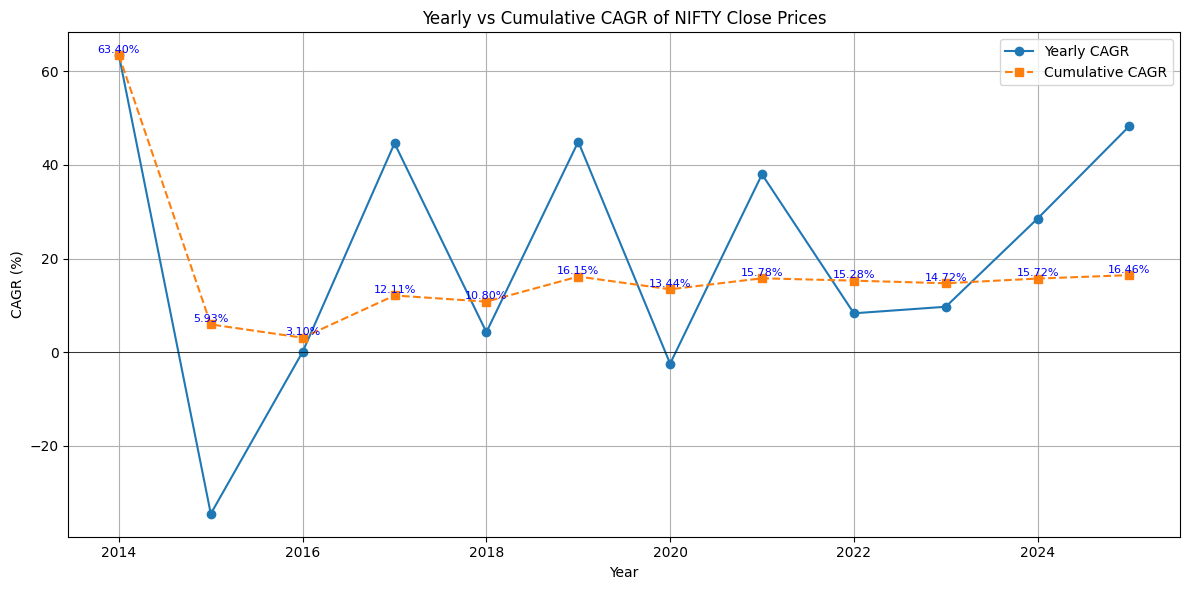

Available Expirations: ('2025-05-16', '2025-06-20', '2025-09-19', '2026-01-16', '2026-06-18', '2027-01-15')
       contractSymbol             lastTradeDate  strike  lastPrice  bid  ask  \
0  IBN250516C00029000 2025-04-21 17:59:00+00:00    29.0       4.60  0.0  0.0   
1  IBN250516C00030000 2025-04-16 16:42:01+00:00    30.0       2.35  0.0  0.0   
2  IBN250516C00031000 2025-04-21 18:29:32+00:00    31.0       2.65  0.0  0.0   
3  IBN250516C00032000 2025-04-21 18:56:14+00:00    32.0       1.85  0.0  0.0   
4  IBN250516C00033000 2025-04-21 18:00:39+00:00    33.0       1.09  0.0  0.0   

   change  percentChange  volume  openInterest  impliedVolatility  inTheMoney  \
0     0.0            0.0       1             0            0.00001        True   
1     0.0            0.0       1             0            0.00001        True   
2     0.0            0.0     101             0            0.00001        True   
3     0.0            0.0      24             0            0.00001        True   
4     

In [148]:
predictor = OptionPredictor('IBN', '2014-01-01', date.today(), 'Close', nfuture = 252)
predictor.data_initiation()

Daily mu (sigma) = 0.04% ± 1.53%
Annual mu (sigma) = 11.18% ± 24.27%


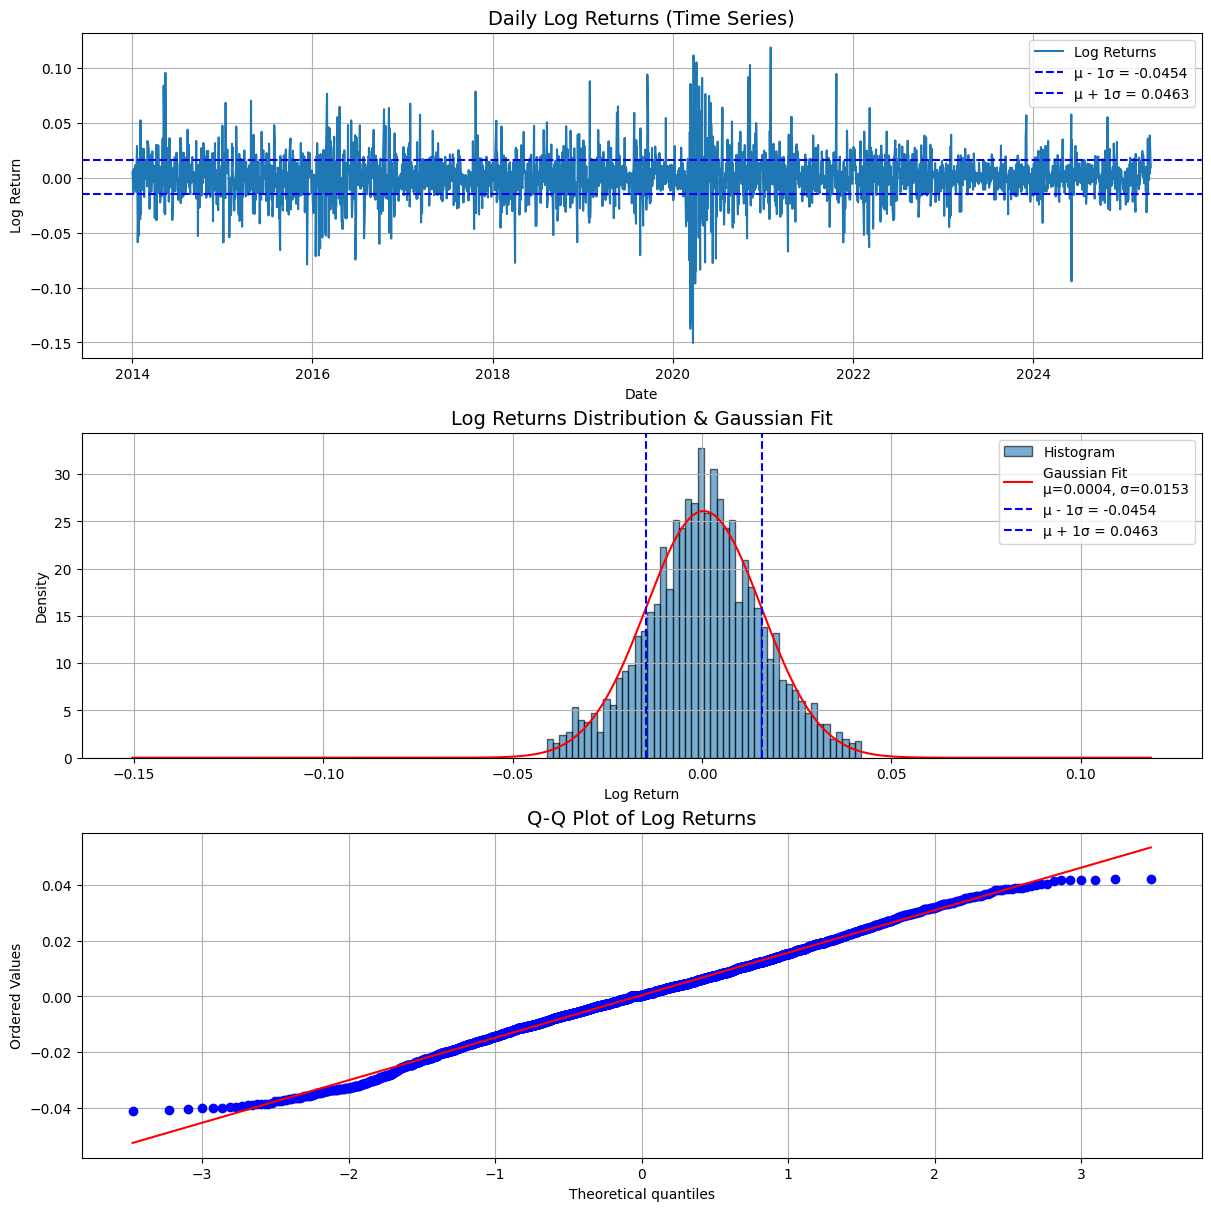

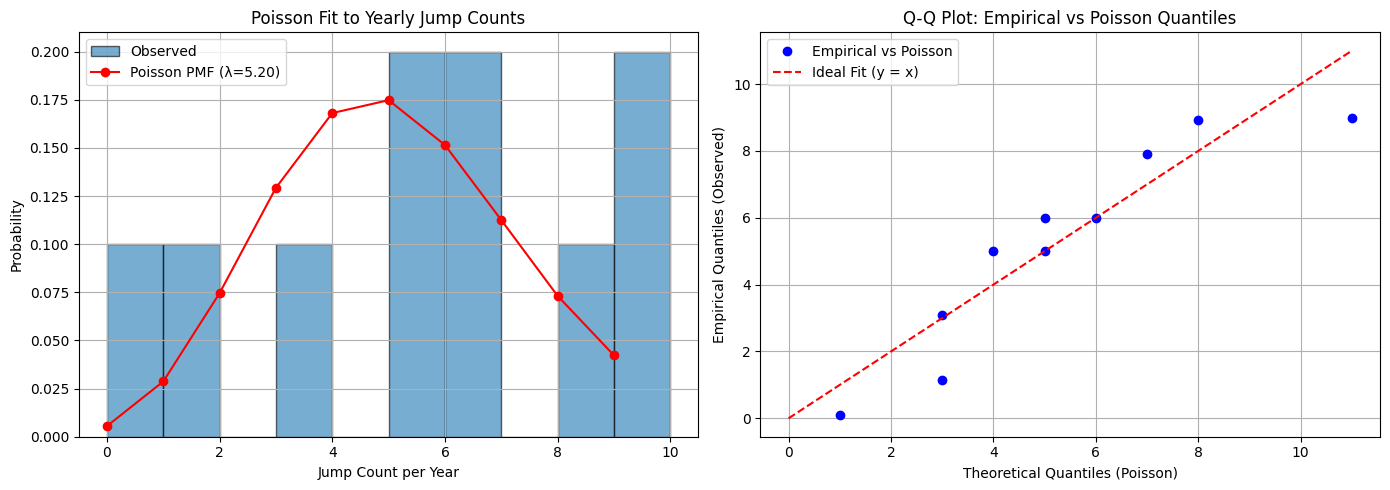

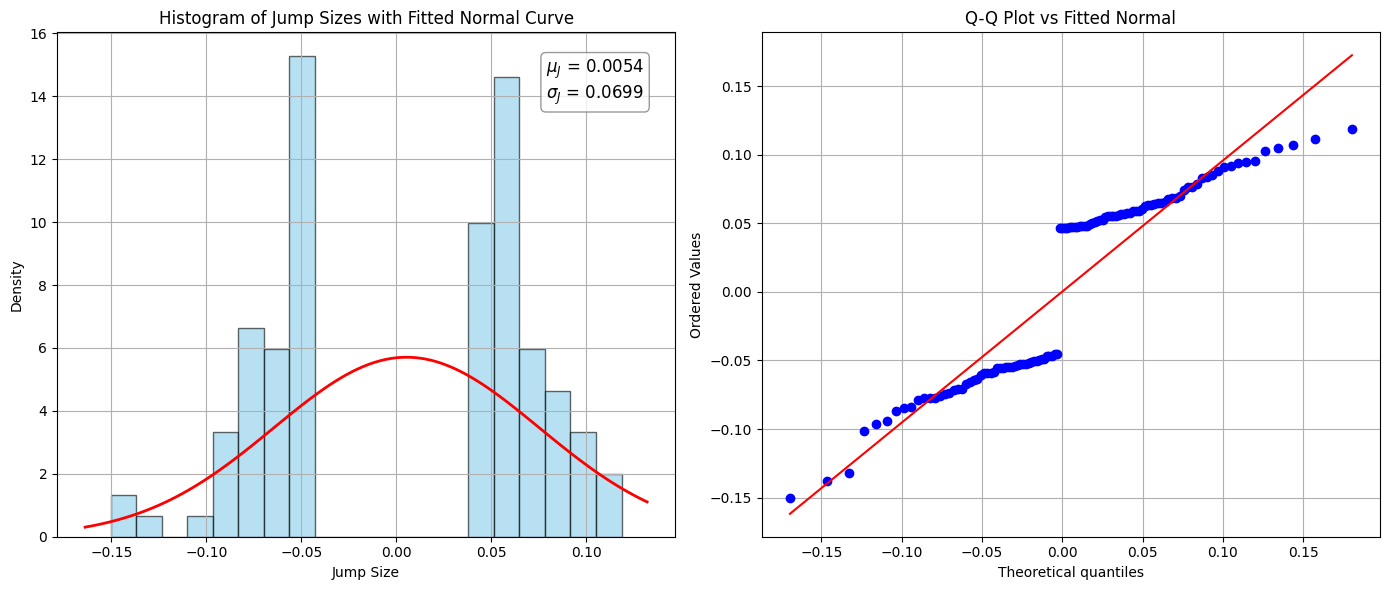

In [149]:
sd_models = ['GBM', 'Merton', 'BinomialTree']
predictor.parameters()

In [155]:
predictor.run_mcmc(npath=1000, model_type='GBM')

print ('--------------------------------------------------------------')

predictor.run_mcmc(npath=1000, model_type='BinomialTree')

<ipython-input-143-e717f49d870d>:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  simulated_prices[ii, t] = simulated_prices[ii, t - 1] * np.exp((self.rfr - 0.5 * sigma_sample**2) * dt + sigma_sample * np.sqrt(dt) * z)


  expirations  call_strike  call_price   IV_call  put_strike  put_price  \
0  2025-05-16         29.0         4.6  0.000010        27.0       0.35   
1  2025-06-20         20.0         9.0  0.000010        15.0       0.05   
2  2025-09-19         20.0        11.0  0.000010        23.0       0.10   
3  2026-01-16         15.0        16.5  0.000010        15.0       0.10   
4  2026-06-18         23.0        10.0  0.000010        18.0       0.20   
5  2027-01-15         15.0        16.9  0.616459        15.0       0.20   

     IV_put  Maturity  CallPrice  PutPrice  Mean S_maturity  
0  0.250007  0.075397   4.654996       0.0        33.676102  
1  1.039067  0.174603  13.731588       0.0        33.876199  
2  0.125009  0.432540  14.037517       0.0        34.406592  
3  0.636722  0.769841  19.224889       0.0        35.133724  
4  0.125009  1.202381  12.133103       0.0        36.040767  
5  0.379889  1.801587  20.070345       0.0        37.361452  
----------------------------------------

<ipython-input-143-e717f49d870d>:109: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  simulated_prices[ii, t] = simulated_prices[ii, t - 1] * (u if move else d)


  expirations  call_strike  call_price   IV_call  put_strike  put_price  \
0  2025-05-16         29.0         4.6  0.000010        27.0       0.35   
1  2025-06-20         20.0         9.0  0.000010        15.0       0.05   
2  2025-09-19         20.0        11.0  0.000010        23.0       0.10   
3  2026-01-16         15.0        16.5  0.000010        15.0       0.10   
4  2026-06-18         23.0        10.0  0.000010        18.0       0.20   
5  2027-01-15         15.0        16.9  0.616459        15.0       0.20   

     IV_put  Maturity  CallPrice  PutPrice  Mean S_maturity  
0  0.250007  0.075397   3.091861       0.0        32.922112  
1  1.039067  0.174603   9.569374       0.0        32.139018  
2  0.125009  0.432540   8.032183       0.0        30.189048  
3  0.636722  0.769841  10.103427       0.0        27.816480  
4  0.125009  1.202381   1.611969       0.0        25.044828  
5  0.379889  1.801587   5.246680       0.0        21.655560  


In [156]:
predictor.run_sde(model_type='GBM')

  expirations  call_strike  call_price   IV_call  put_strike  put_price  \
0  2025-05-16         29.0         4.6  0.000010        27.0       0.35   
1  2025-06-20         20.0         9.0  0.000010        15.0       0.05   
2  2025-09-19         20.0        11.0  0.000010        23.0       0.10   
3  2026-01-16         15.0        16.5  0.000010        15.0       0.10   
4  2026-06-18         23.0        10.0  0.000010        18.0       0.20   
5  2027-01-15         15.0        16.9  0.616459        15.0       0.20   

     IV_put  Maturity  CallPrice  PutPrice  Mean S_maturity  
0  0.250007  0.075397   4.660893       0.0        32.922112  
1  1.039067  0.174603  13.738429       0.0        32.139018  
2  0.125009  0.432540  14.042369       0.0        30.189048  
3  0.636722  0.769841  19.207098       0.0        27.816480  
4  0.125009  1.202381  12.130845       0.0        25.044828  
5  0.379889  1.801587  20.066867       0.0        21.655560  
